## Trotterized Schwinger Model

The Schwinger Model is interesting to simulate as it is the one of the simplest gauge theores to display characteristic QCD features (confinement, Spontaneous Chiral Symmetry Breaking). The attempt at a Trotterization-based quantum simulation shown here is based on the work [here](https://quantum-journal.org/papers/q-2020-08-10-306/pdf/). 

The Lattice Hamiltonian can be expressed as:
$$H = H_E + H_I + H_M$$

Term $H_E$ relates to the energy of the electric fields in the gauge links, $H_I$ represents the minimal couplicng of the Dirac and gauge fields, and $H_M$ represents the mass energy of the fermions. Bosons are associated with the lattice links while fermions are associated witht he sites. The site occupation has the following interpretation: occupied even site ∼ presence of a positron, empty odd site ∼ presence of an electron. An $N$ size lattice is used to represent an $N/2$ sized physical lattice.

In [2]:
import cirq
import numpy as np
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma, show_bloqs
from typing import *
import sympy
from qualtran import SoquetT
from qualtran.symbolics import SymbolicFloat, SymbolicInt
from qualtran.bloqs.basic_gates import CNOT, Hadamard, XGate, SU2RotationGate, SGate
import attrs

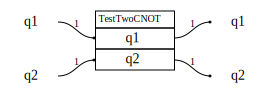

In [3]:
# show_bloq() test
class TestTwoCNOT(Bloq):
    @property
    def signature(self) -> Signature:
        return Signature.build(q1=1, q2=1)

    def build_composite_bloq(
        self, bb: 'BloqBuilder', q1: 'Soquet', q2: 'Soquet'
    ) -> Dict[str, 'Soquet']:
        q1, q2 = bb.add(CNOT(), ctrl=q1, target=q2)
        q1, q2 = bb.add(CNOT(), ctrl=q2, target=q1)
        return {'q1': q1, 'q2': q2}

show_bloq(TestTwoCNOT())

First I will define a bloq representing the hopping terms $T_r$ defined on the paper. The first step when defining such a bloq is to define the signature, essentially a list of registers that the bloq will act on. In this case the bloq represents the interaction between sites $r$ and $r+1$. The link register is also involved in the hopping terms, with links represented in a binary registed for the electric fields. The size of this electric field register depends on the chosen cutoff for their Hilbert space. Next I will define the composite bloq representing the operations performed on the qubit.


To do this, we need an `RzGate` Bloq and Bloq's for the incrementer and decrementer.

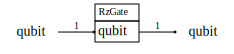

[[0.70710678-0.70710678j 0.        +0.j        ]
 [0.        +0.j         0.70710678+0.70710678j]]


/home/sam/GitHub2/Schwinger_model/schwinger_env/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [4]:
@attrs.frozen
class RzGate(Bloq):
    """
    A class representing the Rz gate.

    Attributes:
        gamma (float): The rotation paramete.
    """

    gamma: float  # The rotation parameter for the Z-axis

    @property
    def signature(self) -> Signature:
        """
        Define the signature for a single-qubit gate.
        """
        return Signature.build(qubit=1)

    def build_composite_bloq(self, bb: BloqBuilder, *, qubit: SoquetT) -> Dict[str, SoquetT]:
        """
        Decompose the generic SU2 rotation into an RzGate.
    
        """
        theta = 0
        phi = 0
        lambda_param = -self.gamma + np.pi  
        alpha = (self.gamma / 2) + np.pi    

        qubit = bb.add(SU2RotationGate(theta, phi, lambda_param, alpha), q=qubit)

        # Return the resulting qubit after the operation
        return {'qubit': qubit}


# Example usage of the RzGate with a pi/2 rotation
Z_rot_gate = RzGate(np.pi / 2)

show_bloq(Z_rot_gate)

# Perform tensor contraction and print the result
print(Z_rot_gate.tensor_contract())

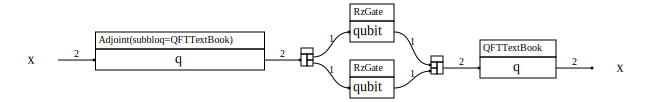

In [5]:
from qualtran.bloqs.qft import QFTTextBook

@attrs.frozen
class Incrementer(Bloq):
    """
    A class representing an Incrementer that increments an 'm'-qubit register by 1.

    Attributes:
        m (int): The number of qubits to increment.
    """

    m: int  # Number of qubits as input

    @property
    def signature(self) -> Signature:
        """
        Define the signature for the Incrementer Bloq. 
        The input and output are both 'm' qubits.
        """
        return Signature.build(x=self.m)

    def build_composite_bloq(self, bb: BloqBuilder, *, x: SoquetT) -> Dict[str, SoquetT]:
        """
        Decompose the incrementer operation using the Quantum Fourier Transform and Rz rotations.
        This function performs an increment-by-1 operation on the 'm'-qubit input.
        """
        
        # Apply the inverse QFT to the input qubits.
        x = bb.add(QFTTextBook(self.m).adjoint(), q=x)

        # Split the qubits for applying rotation gates.
        xs = bb.split(x)
        
        # Apply an Rz gate to each qubit with an appropriate rotation angle.
        for i in range(len(xs)):
            angle = 2 * np.pi * 2**i / (2**self.m)  # Rotation angle calculation
            xs[i] = bb.add(RzGate(angle), qubit=xs[i])

        # Rejoin the qubits after applying rotations.
        x = bb.join(xs)

        # Apply the QFT to the qubits to complete the increment operation.
        x = bb.add(QFTTextBook(self.m), q=x)

        # Return the resulting qubits after the increment operation.
        return {'x': x}
    

@attrs.frozen
class Decrementer(Bloq):
    """
    A class representing a Decrementer, which decrements an 'm'-qubit register by 1.

    NOT DEFINED YET
    """
    
    m: int  # Number of qubits as input

    @property
    def signature(self):
        # Creating a register for each qubit
        return Signature.build(x=self.m)
    

inc = Incrementer(2)
show_bloq(inc.decompose_bloq())

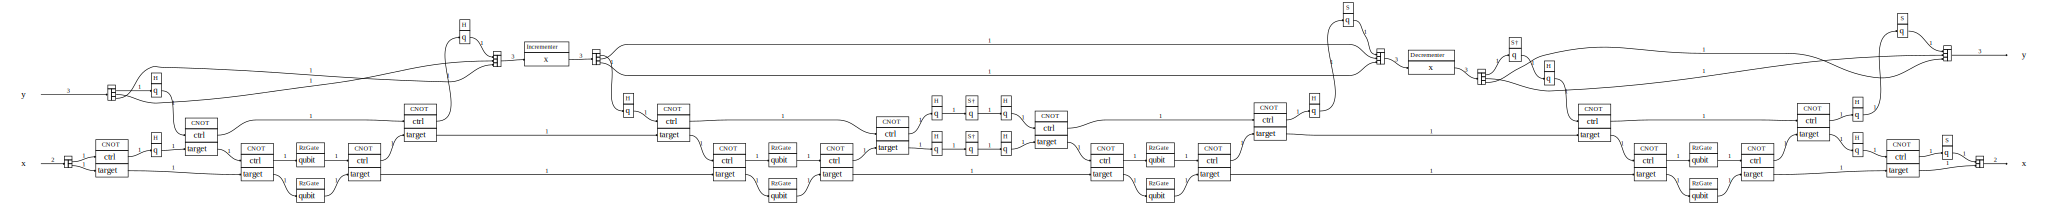

In [6]:
@attrs.frozen
class HoppingTerm(Bloq):
    n: int = 2
    m: int = 2
    
    @property
    def signature(self) -> Signature:
        return Signature.build(x=self.n, y=self.m)

    angle: SymbolicFloat = 1 
    eps: SymbolicFloat = 1e-9 
    
    def build_composite_bloq(
            self, bb: BloqBuilder, *, x: SoquetT, y: SoquetT
    ) -> Dict[str, SoquetT]:
        xs = bb.split(x)
        ys = bb.split(y)

        # Using the order of gates from her code
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        xs[0] = bb.add(Hadamard(), q=xs[0])
        ys[0] = bb.add(Hadamard(), q=ys[0])

        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])

        xs[0] = bb.add(RzGate(self.angle), qubit=xs[0])
        xs[1] = bb.add(RzGate(-self.angle), qubit=xs[1])

        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])

        ys[0] = bb.add(Hadamard(), q=ys[0])

        rejoined_y = bb.join(ys)
        # Apply the Incrementer to the entire ys register as a multi-qubit gate
        rejoined_y = bb.add(Incrementer(self.m), x = rejoined_y)

        ys = bb.split(rejoined_y)

        ys[0] = bb.add(Hadamard(), q=ys[0])

        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])

        xs[0] = bb.add(RzGate(self.angle), qubit=xs[0])
        xs[1] = bb.add(RzGate(-self.angle), qubit=xs[1])

        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])

        xs[0] = bb.add(Hadamard(), q=xs[0])
        ys[0] = bb.add(Hadamard(), q=ys[0])
        xs[0] = bb.add(SGate().adjoint(), q=xs[0])
        ys[0] = bb.add(SGate().adjoint(), q=ys[0])
        xs[0] = bb.add(Hadamard(), q=xs[0])
        ys[0] = bb.add(Hadamard(), q=ys[0])

        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])

        xs[0] = bb.add(RzGate(self.angle), qubit=xs[0])
        xs[1] = bb.add(RzGate(-self.angle), qubit=xs[1])

        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])

        ys[0] = bb.add(Hadamard(), q=ys[0])
        ys[0] = bb.add(SGate(), q=ys[0])

        rejoined_y = bb.join(ys)
        # Apply the decrementer to the entire ys register as a multi-qubit gate
        rejoined_y = bb.add(Decrementer(self.m), x = rejoined_y)

        ys = bb.split(rejoined_y) 
        
        ys[0] = bb.add(SGate().adjoint(), q=ys[0])
        ys[0] = bb.add(Hadamard(), q=ys[0])

        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])

        xs[0] = bb.add(RzGate(self.angle), qubit=xs[0])
        xs[1] = bb.add(RzGate(-self.angle), qubit=xs[1])

        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        ys[0], xs[0] = bb.add(CNOT(), ctrl=ys[0], target=xs[0])

        xs[0] = bb.add(Hadamard(), q=xs[0])
        ys[0] = bb.add(Hadamard(), q=ys[0])

        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        xs[0] = bb.add(SGate(), q=xs[0])
        ys[0] = bb.add(SGate(), q=ys[0])
        
        return {
            'x': bb.join(xs),
            'y': bb.join(ys),
        }
show_bloq(HoppingTerm(2, 3).decompose_bloq())

#### Implementing Mass and Electric Energy Terms
Now we want to implement the unitary given in Eq(70). This currently does not use the identity to reduce the number of CNOT's (given by Eq(77)).

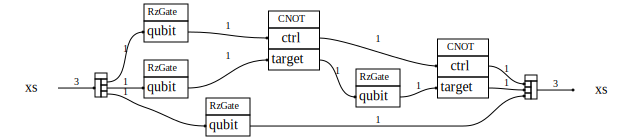

In [16]:
@attrs.frozen
class mass_energy_terms(Bloq):
    eta: int  # Number of qubits in xs register
    t: float  # Timestep multiplier for Rz gate angles

    @property
    def signature(self) -> Signature:
        return Signature.build(xs=self.eta)

    def build_composite_bloq(
        self, bb: BloqBuilder, *, xs: SoquetT
    ) -> Dict[str, SoquetT]:
        qubits = bb.split(xs)

        # Initial Rz gates with angles t * 2^i on each qubit corresponding to linear term in Eq.70 
        for i in range(self.eta):
            angle = self.t * (2 ** i)
            qubits[i] = bb.add(RzGate(angle), qubit=qubits[i])

        # Implementing the quadratic term in Eq.70 
        for j in range(self.eta - 2):
            for k in range(j + 1, self.eta - 1):
                angle = self.t * (2 ** (j + k - 1))
                
                # CNOT(j -> k)
                qubits[j], qubits[k] = bb.add(CNOT(), ctrl=qubits[j], target=qubits[k])

                # Rz(2 * angle) on target qubit k
                qubits[k] = bb.add(RzGate(2 * angle), qubit=qubits[k])

                # CNOT(j -> k) again to complete the operation
                qubits[j], qubits[k] = bb.add(CNOT(), ctrl=qubits[j], target=qubits[k])

        return {'xs': bb.join(qubits)}

# To visualize the bloq
show_bloq(mass_energy_terms(eta=3, t = 1).decompose_bloq())

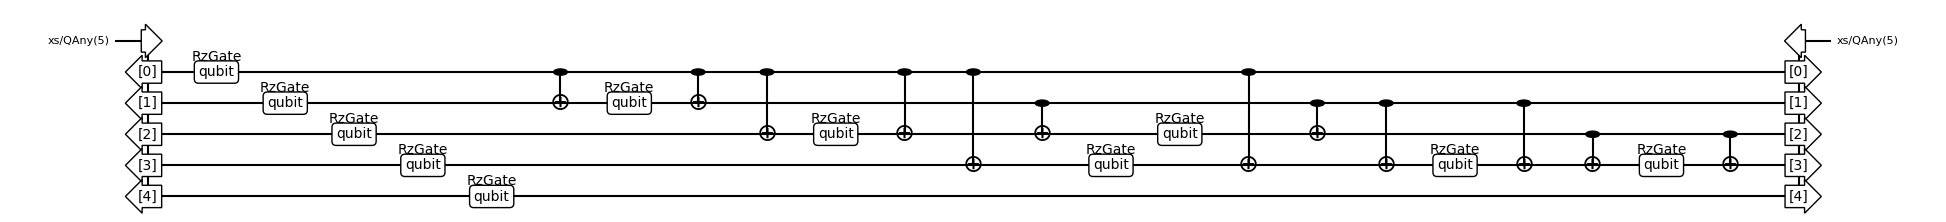

In [17]:
from qualtran.drawing import get_musical_score_data, draw_musical_score
cbloq = mass_energy_terms(eta=5, t = 1).decompose_bloq()
msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.set_figwidth(20)